In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import division
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY,date2num,num2date,AutoDateLocator
from matplotlib.finance import quotes_historical_yahoo_ohlc, candlestick_ohlc,candlestick2_ochl

from stockapp import models as stkmd
from dataapp import models as dtamd
from dataapp import tasks as dtatks
from dataapp import libs as dtalibs
from stockapp import tasks as stktks
from stockapp import libs as stklibs
import featureapp as ftapp
import utility as uty
import itertools as itt
import multiprocessing as mp
from django.db import connection,connections
from django.db import reset_queries
import time 
import pandas as pd
import numpy as np
import inspect
import imp
import datetime
from talib.abstract import *
import utility.models as utmd
import stockapp.libs as stklib
from utility import codemanager as cdmng
import json
from django.contrib.auth.models import AnonymousUser
import threading

/usr/local/lib/python2.7/dist-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [27]:
print stkmd.ComputeStatus_Stockdownload.objects.filter(Status='Success').count()
print stkmd.ComputeStatus_Stockdownload.objects.filter(Status='Fail').count()
print stkmd.ComputeStatus_Stockdownload.objects.filter(Status='ToDo').count()

7098
842
0


In [28]:
stkgrpids=list(stkmd.StockGroup.objects.get(GroupName='Sector: Utilities').Symbol.all().values_list('id',flat=True))

In [170]:
Todate=pd.datetime.today().date()
Fromdate=pd.datetime(2002,1,1).date()
stk=stkmd.Stockmeta.objects.get(Symbol='UTIAvg')
df=dtalibs.GetStockData([stk.id],Fromdate,Todate,'concat')
df.head()

 Time for GetStockData =  0.428045034409


,Close,Open,High,Low,Volume,Symbol
Date,,,,,,
2002-01-01,NaN,NaN,NaN,NaN,0,UTIAvg
2002-01-02,32.81,32.41,32.94,31.78,491102,UTIAvg
2002-01-03,32.20,32.26,32.48,31.83,408770,UTIAvg
2002-01-04,32.19,32.17,32.45,31.80,508387,UTIAvg
2002-01-07,32.60,32.49,32.79,32.17,395070,UTIAvg


In [173]:
TUT=set(df.index)-set(T)
TUT

{datetime.date(2002, 1, 1),
 datetime.date(2002, 1, 21),
 datetime.date(2002, 2, 18),
 datetime.date(2002, 3, 29),
 datetime.date(2002, 5, 27),
 datetime.date(2002, 7, 4),
 datetime.date(2002, 9, 2),
 datetime.date(2002, 11, 28),
 datetime.date(2002, 12, 25),
 datetime.date(2003, 1, 1),
 datetime.date(2003, 1, 20),
 datetime.date(2003, 2, 17),
 datetime.date(2003, 4, 18),
 datetime.date(2003, 5, 26),
 datetime.date(2003, 7, 4),
 datetime.date(2003, 9, 1),
 datetime.date(2003, 11, 27),
 datetime.date(2003, 12, 25),
 datetime.date(2004, 1, 1),
 datetime.date(2004, 1, 19),
 datetime.date(2004, 2, 16),
 datetime.date(2004, 4, 9),
 datetime.date(2004, 5, 31),
 datetime.date(2004, 6, 11),
 datetime.date(2004, 7, 5),
 datetime.date(2004, 9, 6),
 datetime.date(2004, 11, 25),
 datetime.date(2004, 12, 24),
 datetime.date(2005, 1, 17),
 datetime.date(2005, 2, 21),
 datetime.date(2005, 3, 25),
 datetime.date(2005, 5, 30),
 datetime.date(2005, 7, 4),
 datetime.date(2005, 9, 5),
 datetime.date(2005,

In [175]:
print(len(df.index))
print (len(df.index.unique()))

4000
4000


In [154]:
stk.LastPriceUpdate=None
stk.save()
print stk.Lastdate,stk.Startdate,stk.LastPriceUpdate

None None None


In [10]:
dtamd.Stockprice.objects.filter(Symbol_id=stk.id)

<QuerySet []>

In [13]:
stkmd.Stockmeta.objects.filter(Derived=True).update(Lastdate=None,Startdate=None,LastPriceUpdate=None)

1

# Add Index

In [143]:
stkmd.IndexComputeCode.objects.first().Code

u'from __future__ import division\nimport utility.models as utmd\n# import stockapp.models as stkmd\n# import dataapp.models as dtamd\nimport dataapp.libs as dtalibs\nimport pandas as pd\n\n\nclass AveragePrice(utmd.index):\n\t"""\n\tTake the average price of all the stocks in the group\n\t"""\n\t\n\tdef __init__(self,*args,**kwargs):\n\t\tsuper(AveragePrice,self).__init__(*args,**kwargs)\n\n\t\tself.register(description="Average Close of Group",name="AverageClose",label="AvgClose",resulttype=pd.DataFrame,\n\t\t\t\t\t\tscale=[\'absolute\',\'%\'],operations=[\'<\',\'>\',\'<=\',\'>=\',\'!=\',\'between\'],computefeatures=True)\n\t\tself.register(description="Volume Average Close of Group",name="VolAvgClose",label="VolAvgClose",resulttype=pd.DataFrame,\n\t\t\t\t\t\tscale=[\'absolute\',\'%\'],operations=[\'<\',\'>\',\'<=\',\'>=\',\'!=\',\'between\'],computefeatures=True)\n\t\t\n\n\tdef compute(self,*args,**kwargs):\n\t\tFromdate=kwargs.get(\'Fromdate\',pd.datetime(2002,1,1).date() )\n\t\tTo

 Time for GetStockData =  0.195077180862


# Building Query

In [37]:
url='http://ec2-54-183-21-11.us-west-1.compute.amazonaws.com:8080/?symbols=TSLA,MSFT,AAPL&from=2012-01-01&to=2017-01-01'
import urllib2
response = urllib2.urlopen(url)
html = response.read()
D=json.loads(html)

In [137]:
D['query']

{u'from': u'2012-01-01',
 u'symbols': [u'TSLA', u'MSFT', u'AAPL'],
 u'to': u'2017-01-01'}

In [68]:
print len(D['result'])
# pd.DataFrame(D['result'])
df=pd.DataFrame()
for d in D['result']:
    df=pd.concat([df,pd.DataFrame(d['quotes'])])
df['date']=df['date'].apply(lambda x : pd.to_datetime(x))
df

3


,adjClose,avgVolume,cci5,cci50,close,date,ema8,hasCherries,high,low,...,macdHistogram,macdSignal,open,rsi14,sma20,sma50,snapback,stddev20,symbol,volume
0,28.080000,NaN,NaN,NaN,28.080000,2012-01-03 05:00:00,NaN,None,29.500000,27.650000,...,NaN,NaN,28.940001,NaN,NaN,NaN,NaN,NaN,TSLA,928100
1,27.709999,NaN,NaN,NaN,27.709999,2012-01-04 05:00:00,NaN,None,28.670000,27.500000,...,NaN,NaN,28.209999,NaN,NaN,NaN,NaN,NaN,TSLA,630100
2,27.120001,NaN,NaN,NaN,27.120001,2012-01-05 05:00:00,NaN,None,27.930000,26.850000,...,NaN,NaN,27.760000,NaN,NaN,NaN,NaN,NaN,TSLA,1005500
3,26.910000,NaN,NaN,NaN,26.910000,2012-01-06 05:00:00,NaN,None,27.790001,26.410000,...,NaN,NaN,27.200001,NaN,NaN,NaN,NaN,NaN,TSLA,986300
4,27.250000,NaN,-73.847209,NaN,27.250000,2012-01-09 05:00:00,NaN,None,27.490000,26.120001,...,NaN,NaN,27.000000,NaN,NaN,NaN,NaN,NaN,TSLA,897000
5,27.620001,NaN,39.157526,NaN,27.620001,2012-01-10 05:00:00,NaN,None,27.760000,27.250000,...,NaN,NaN,27.440001,NaN,NaN,NaN,NaN,NaN,TSLA,671800
6,28.230000,NaN,128.226640,NaN,28.230000,2012-01-11 05:00:00,NaN,None,28.379999,27.299999,...,NaN,NaN,27.620001,NaN,NaN,NaN,NaN,NaN,TSLA,672300
7,28.250000,NaN,102.695699,NaN,28.250000,2012-01-12 05:00:00,27.646250,None,28.620001,27.809999,...,NaN,NaN,28.480000,NaN,NaN,NaN,NaN,NaN,TSLA,729300
8,22.790001,NaN,-159.180478,NaN,22.790001,2012-01-13 05:00:00,26.567084,None,28.500000,22.639999,...,NaN,NaN,28.400000,NaN,NaN,NaN,NaN,NaN,TSLA,5500400
9,26.600000,NaN,-15.782825,NaN,26.600000,2012-01-17 05:00:00,26.574398,None,27.340000,26.410000,...,NaN,NaN,26.620001,NaN,NaN,NaN,NaN,NaN,TSLA,4651600


 Time for GetStockData =  0.0801451206207
56


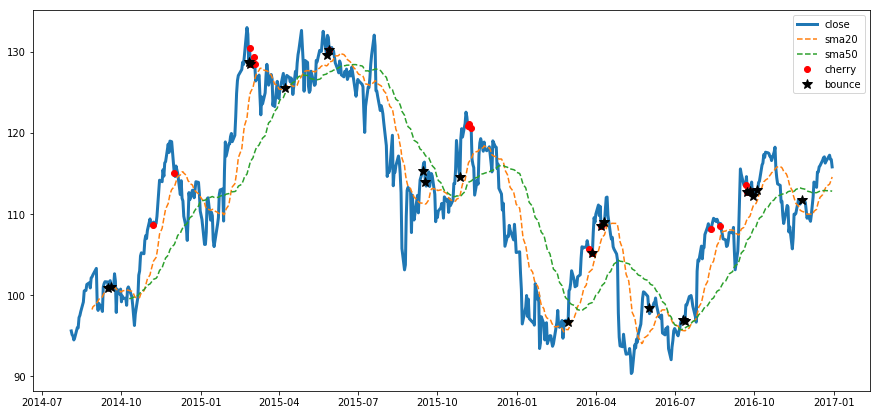

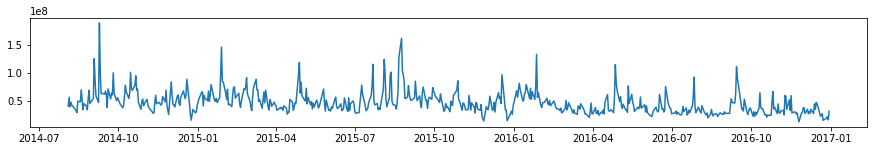

In [206]:
Todate=pd.datetime(2017,1,1).date()
Fromdate=pd.datetime(2014,8,1).date()
stk=stkmd.Stockmeta.objects.get(Symbol='AAPL')
df=dtalibs.GetStockData([stk.id],Fromdate,Todate,'concat')

# uses close prices (default)
df[['Open','High','Low','Close','Volume']]
inputs1 = {
    'open': df['Open'].values,
    'high': df['High'].values,
    'low': df['Low'].values,
    'close': df['Close'].values,
    'volume': df['Volume'].values
}
output = SMA(inputs1, timeperiod=25)
df['sma20']=df['Close'].rolling(window=20).mean()
df['smastd20']=df['Close'].rolling(window=20).std()
df['ema20']=df['Close'].ewm(span=20).mean()
df['emastd20']=df['Close'].ewm(span=20).std(bias=False)

df['ema8']=df['Close'].ewm(span=8).mean()
df['emastd8']=df['Close'].ewm(span=8).std(bias=False)


df['sma50']=df['Close'].rolling(window=50).mean()
df['smastd50']=df['Close'].rolling(window=50).std()
df['ema50']=df['Close'].ewm(span=50).mean()
df['emastd50']=df['Close'].ewm(span=50).std(bias=False)

df['cci5'] = CCI(inputs1, timeperiod=5)
df['cci50']= CCI(inputs1, timeperiod=50)
df['hasCherries']=(df['cci50']-df['cci5'])>180

def sequentialcluster(dp):
    dp['date']=dp.index.copy()
    dp.index=range(len(dp))
    C=[]
    c=[]
    for i in dp.index[1:]:
        if (dp.loc[i,'date']-dp.loc[i-1,'date']).days<=1:
                c.append(dp.loc[i-1,'date'])
        else:
            if len(c)==0:
                c=[dp.loc[i-1,'date']]
            C.append(c)
            c=[]
    
    C=[c[int(len(c)/2)] for c in C if len(c)>0]
    dC=dp[dp['date'].isin(C)].copy()
    dC.index=dC['date'].copy()
    dC=dC[dC["Close"]>=dC['sma20']].copy()
    
#     for ind in dC.index:
    return dC
        
# C=sequentialcluster(dbsma20)


dp=df[(df.index<Todate) & (df.index>Fromdate)].copy()

dbsma20=dp[abs(dp['Close']-dp['ema20'])/dp['ema20']<= 0.6*dp['emastd20']/dp['ema20']].copy()
# kmeans = KMeans(n_clusters=30, random_state=0).fit(dbsma20['date'].values.reshape(-1,1))
# dateclusters=[pd.to_datetime(f) for f in kmeans.cluster_centers_.reshape(1,-1)[0]]

dC=sequentialcluster(dbsma20)
idx=[]
print len(dC)
for i in range(len(dC)):
    for j in range(len(dp)):
        if dp.index[j]==dC.index[i]:
            break
            
    if (dp.loc[dp.index[j-2]:dp.index[j+3],'Close']-dp.loc[dp.index[j-2]:dp.index[j+3],'sma20']).min()>0:
        idx.append(i)
dC=dC.iloc[idx]

fig,ax=plt.subplots(1,1,figsize=(15,7))
ax.plot(dp.index,dp['Close'],linewidth=3,label='close')
ax.plot(dp.index,dp['sma20'],'--',label='sma20')
ax.plot(dp.index,dp['sma50'],'--',label='sma50')
# ax.plot(dp.index,dp['sma20']+1*dp['smastd20'],'k--',label='+std20')
# ax.plot(dp.index,dp['sma20']-1*dp['smastd20'],'k--',label='-std20')
dc=dp[(dp['hasCherries']==True) & (dp['cci50']>100)].copy()
ax.plot(dc.index,dc['Close'],'r',marker='o',linestyle='',label='cherry')
ax.plot(dC.index,dC['Close'],'k',marker='*',markersize=10,linestyle='',label='bounce')


ax.legend()
fig,ax=plt.subplots(1,1,figsize=(15,2))
ax.plot(dp.index,dp['Volume'])
plt.show()

In [ ]:
def convexity()

 Time for GetStockData =  0.174721002579
247


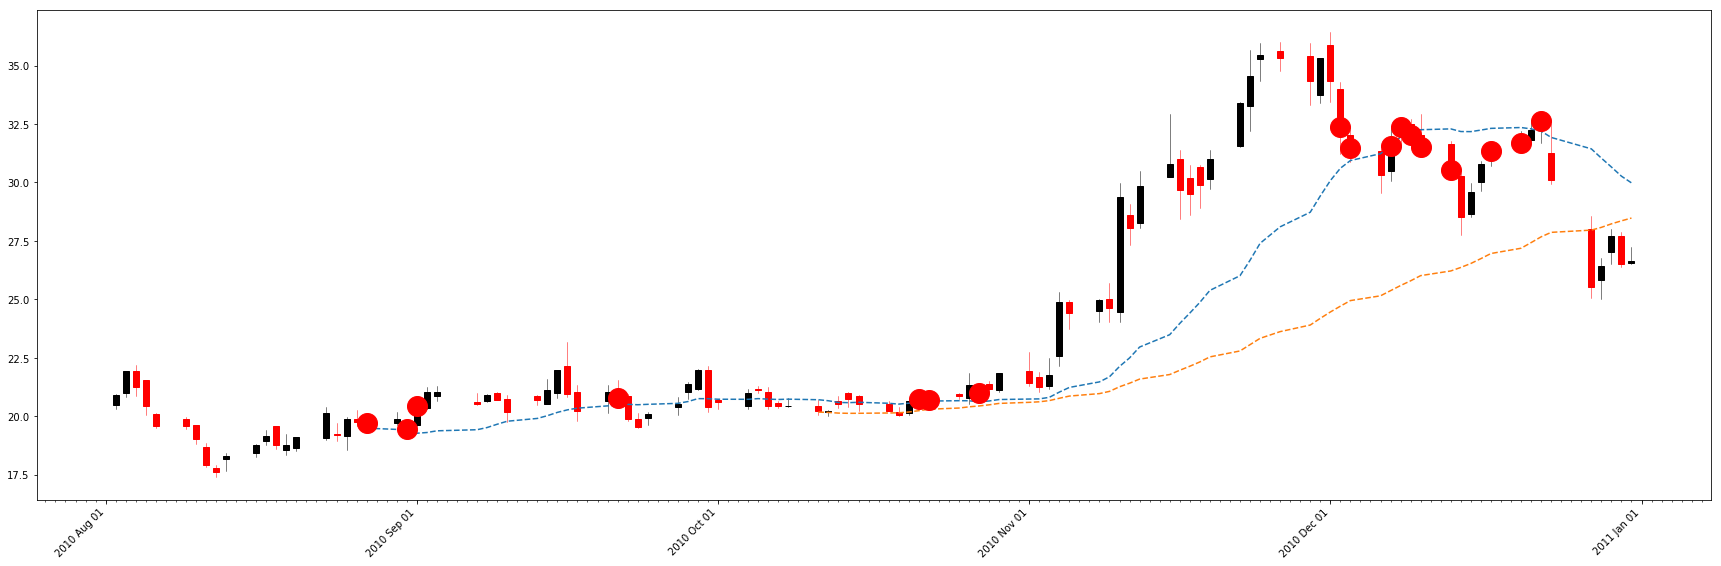

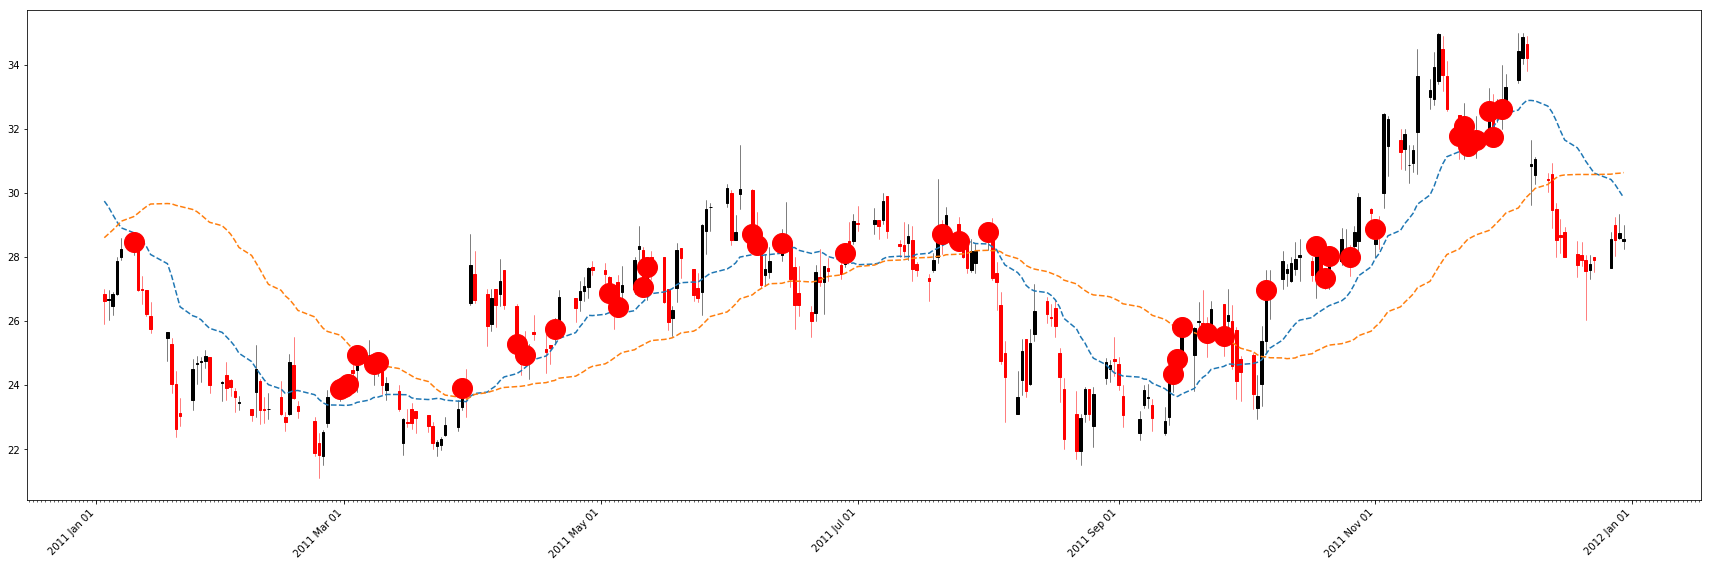

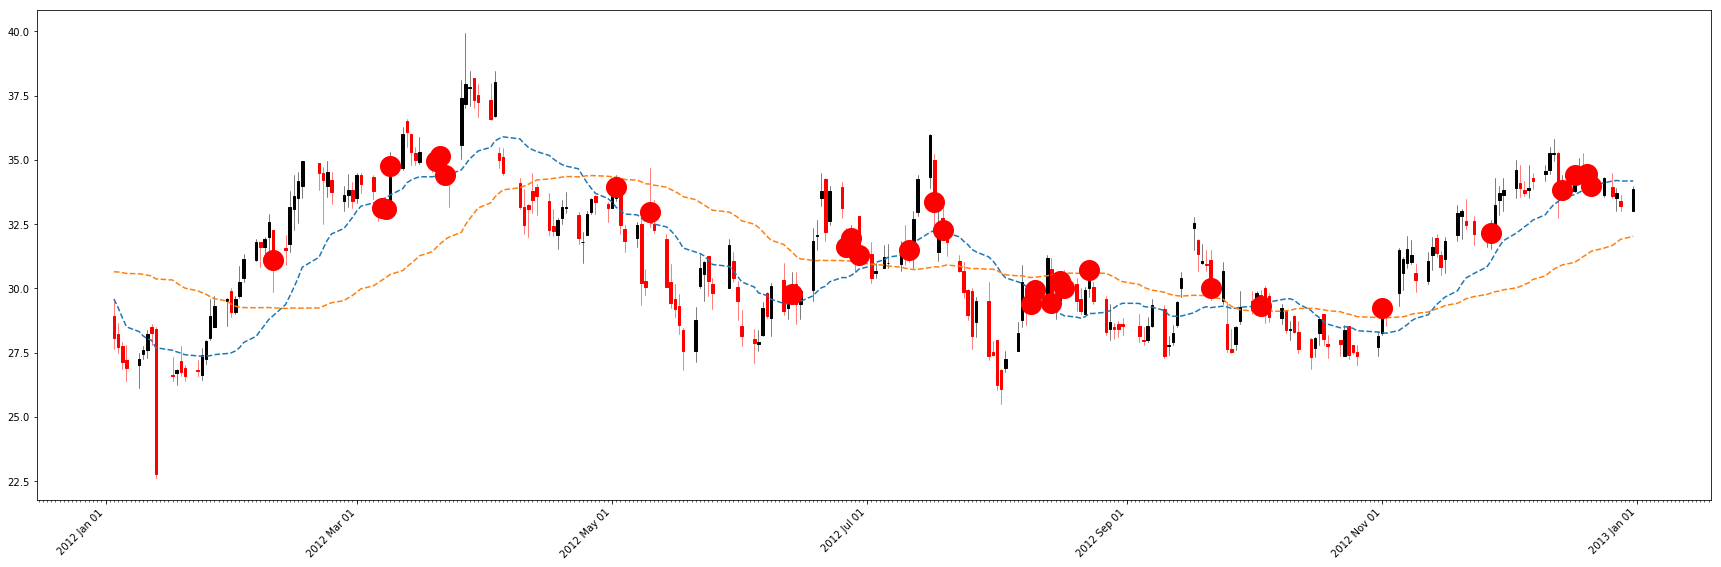

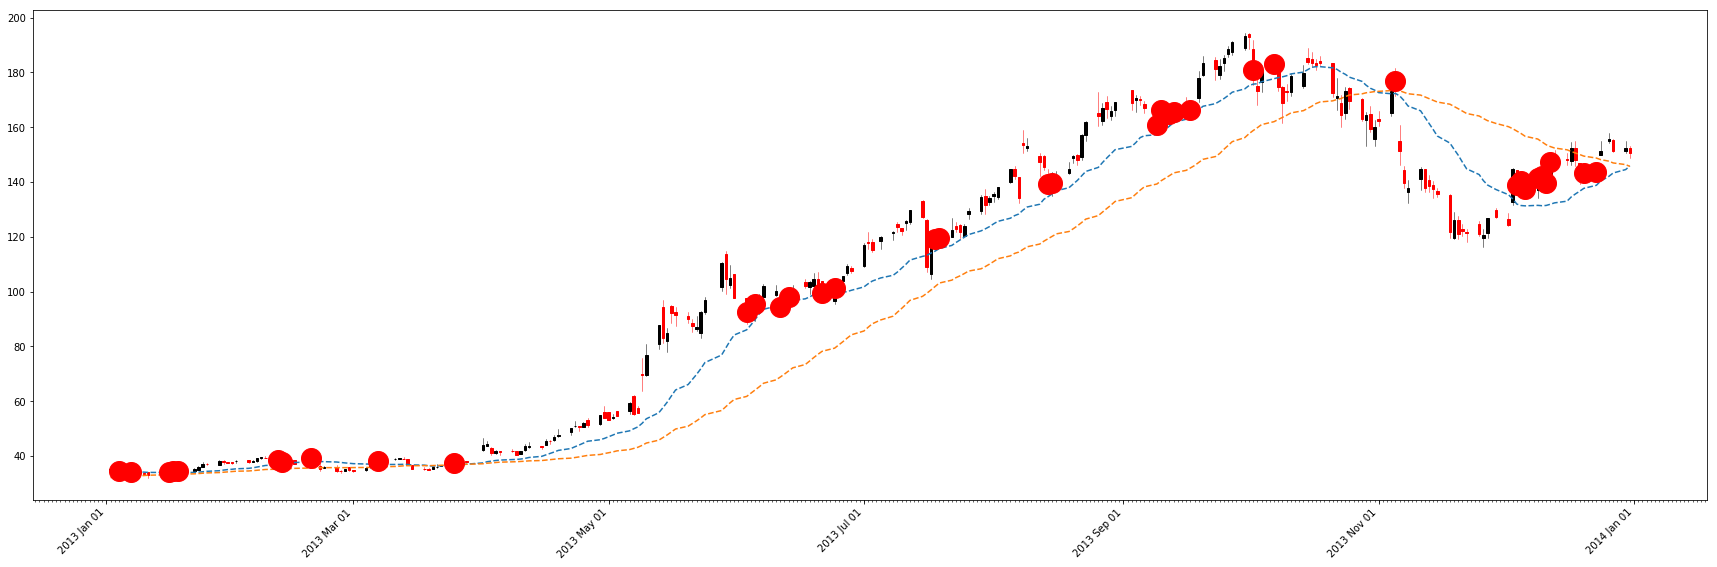

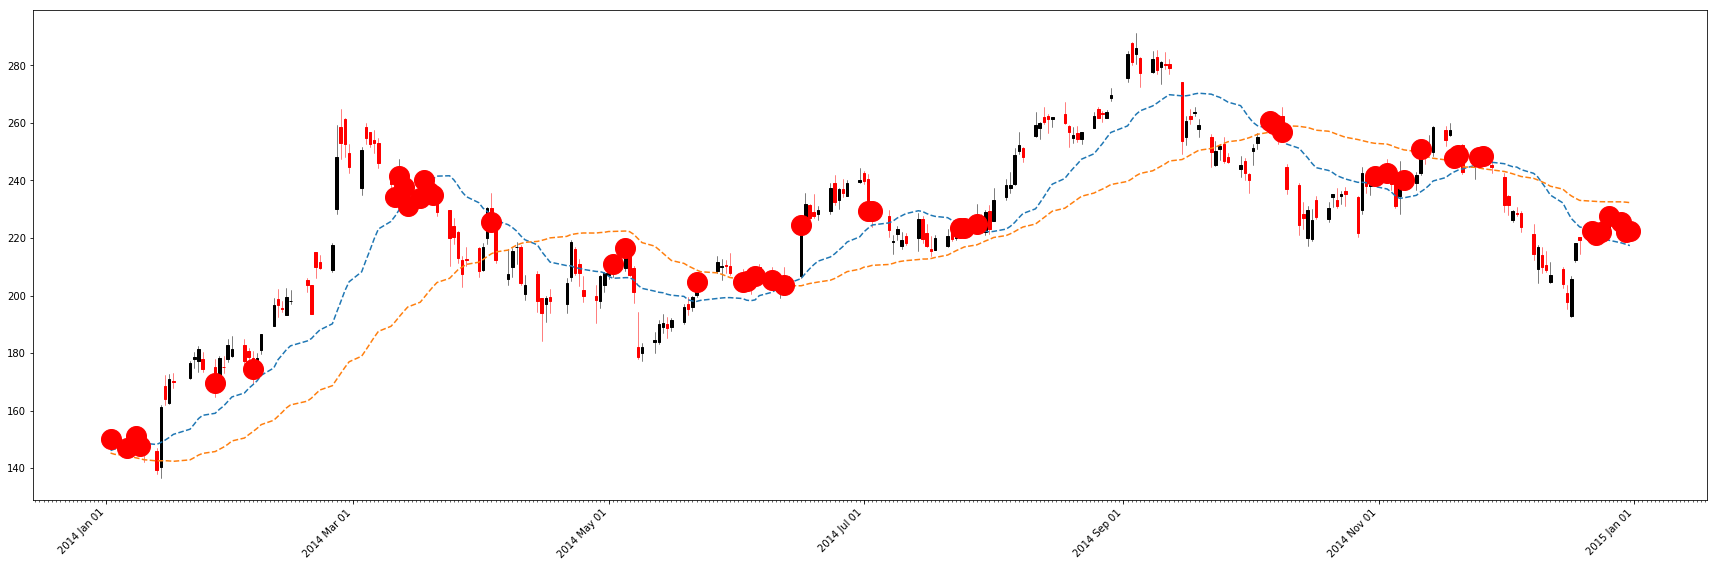

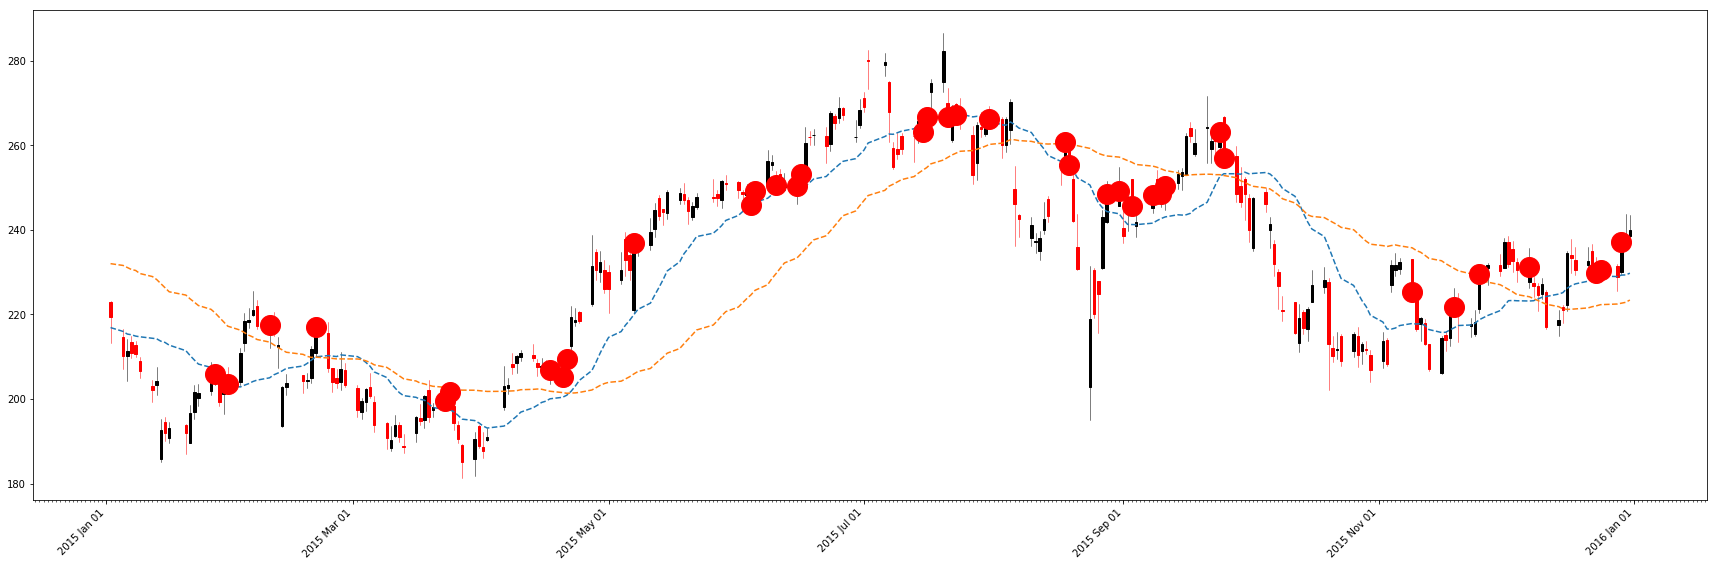

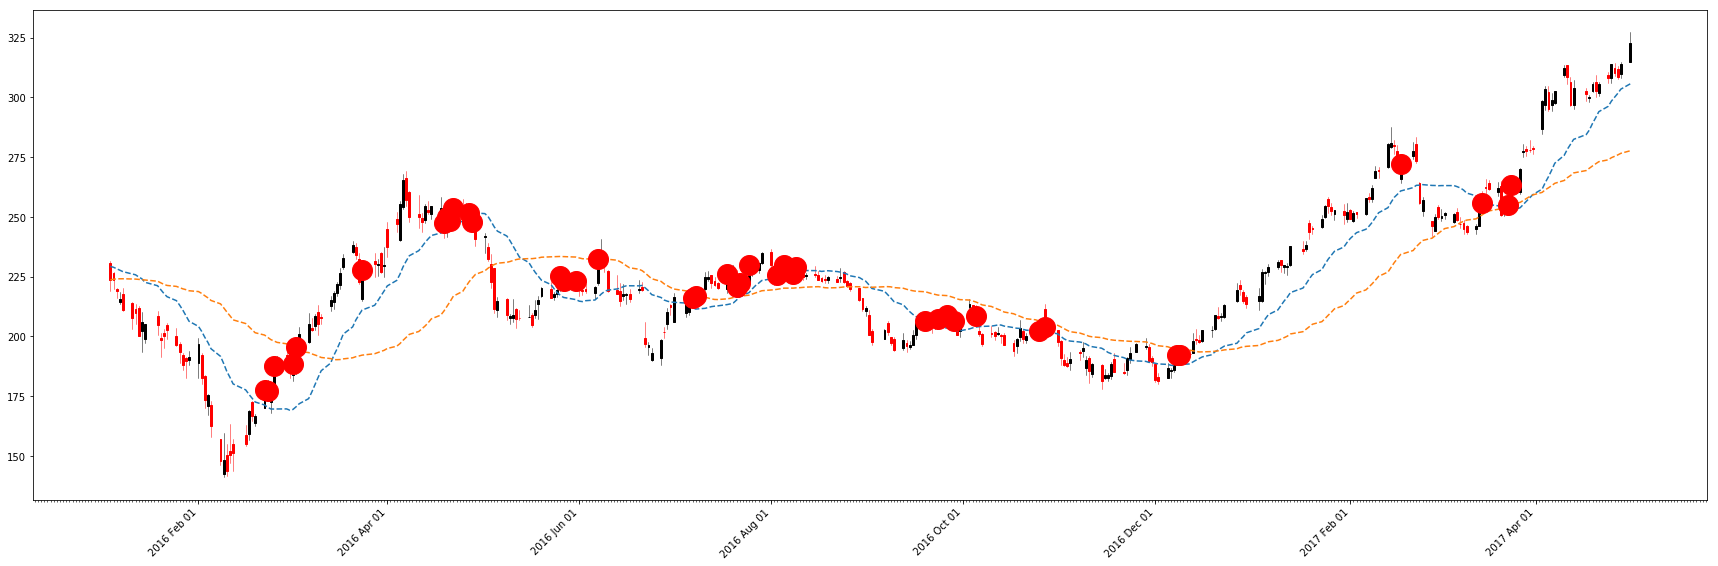

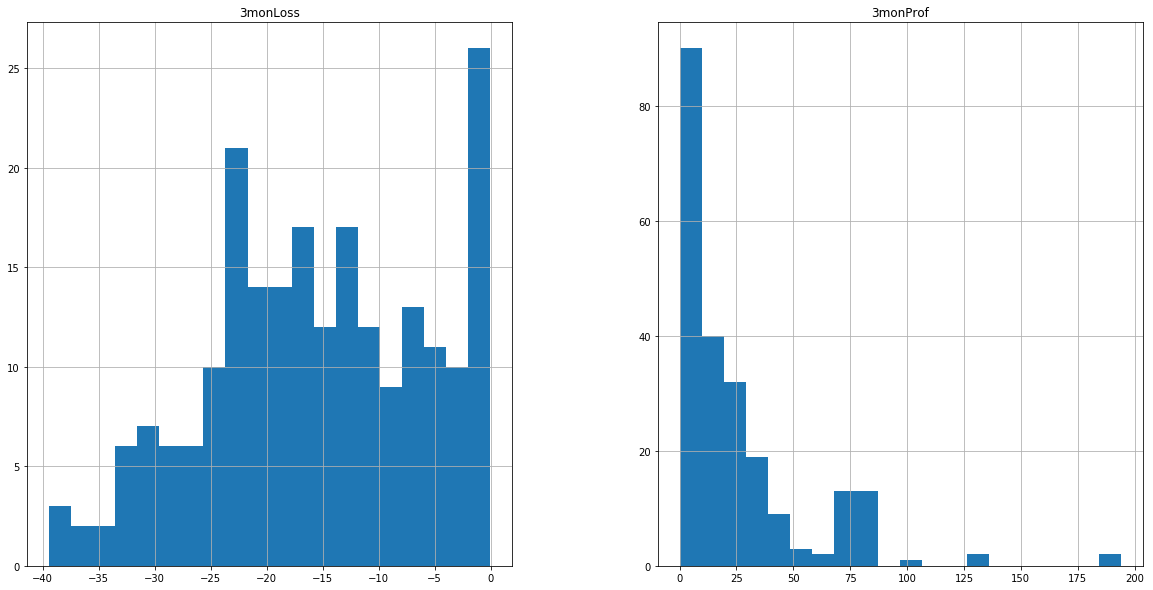

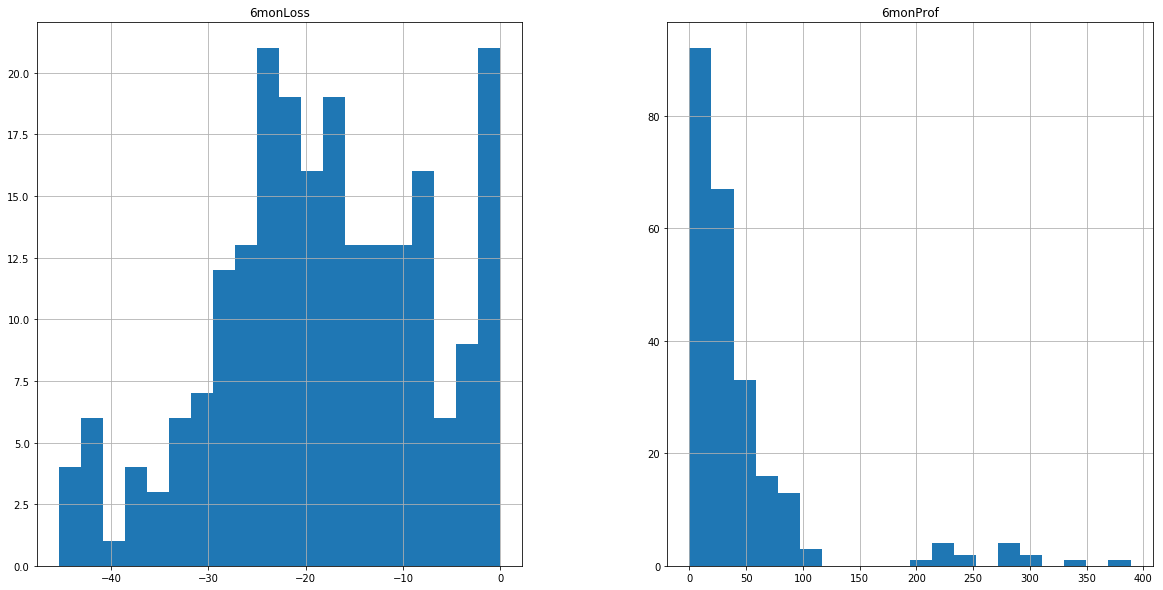

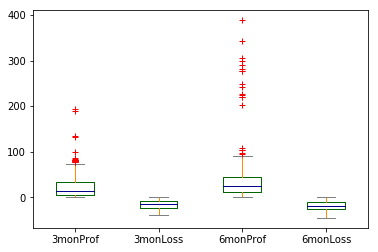

In [14]:
Todate=pd.datetime(2017,5,1).date()
Fromdate=pd.datetime(2010,8,1).date()
stk=stkmd.Stockmeta.objects.get(Symbol='TSLA')
df=dtalibs.GetStockData([stk.id],Fromdate,Todate,'concat')

# uses close prices (default)
df[['Open','High','Low','Close','Volume']]
inputs1 = {
    'open': df['Open'].values,
    'high': df['High'].values,
    'low': df['Low'].values,
    'close': df['Close'].values,
    'volume': df['Volume'].values
}
output = SMA(inputs1, timeperiod=25)
df['sma20']=df['Close'].rolling(window=20).mean()
df['smastd20']=df['Close'].rolling(window=20).std()
df['ema20']=df['Close'].ewm(span=20).mean()
df['emastd20']=df['Close'].ewm(span=20).std(bias=False)

df['ema8']=df['Close'].ewm(span=8).mean()
df['emastd8']=df['Close'].ewm(span=8).std(bias=False)


df['sma50']=df['Close'].rolling(window=50).mean()
df['smastd50']=df['Close'].rolling(window=50).std()
df['ema50']=df['Close'].ewm(span=50).mean()
df['emastd50']=df['Close'].ewm(span=50).std(bias=False)

df['cci5'] = CCI(inputs1, timeperiod=5)
df['cci50']= CCI(inputs1, timeperiod=50)
df['hasCherries']=(df['cci50']-df['cci5'])>180
df['datenum']=date2num(df.index)

def feature1(df,label=None):
#     dp=df[(df['hasCherries']==True) & (df['cci50']>100)].copy()
#     dp=df[df['cci50']>50].copy()
    dp=df.copy()
    dp['date']=dp.index.copy()
    dp['bottom']=dp[['Open','Close']].min(axis=1)

    dbsma20=dp[abs(dp['Low']-dp['ema20'])/dp['ema20']<= 0.2*dp['emastd20']/dp['ema20']].copy()
#     dbsma20=dp[abs(dp['bottom']-dp['sma20'])/dp['sma20']<= 0.3*dp['smastd20']/dp['sma20']].copy()
    
#     dbsma20.index=range(len(dbsma20))
#     C=[]
#     c=[]
#     for i in dbsma20.index[1:]:
#         if (dbsma20.loc[i,'date']-dbsma20.loc[i-1,'date']).days<=1:
#                 c.append(dbsma20.loc[i-1,'date'])
#         else:
#             if len(c)==0:
#                 c=[dbsma20.loc[i-1,'date']]
#             C.append(c)
#             c=[]
    
#     C=[c[int(len(c)/2)] for c in C if len(c)>0]
#     dC=dbsma20[dbsma20['date'].isin(C)].copy()
    
    
    dC=dbsma20
    
    
    dC.index=dC['date'].copy()

    idx=[]
    print len(dC)
    for i in range(len(dC)):
        for j in range(len(df)):
            if df.index[j]==dC.index[i]:
                break
#         if (df.loc[df.index[j-3]:df.index[j],'Low']-df.loc[df.index[j-3]:df.index[j],'sma20']).min()>0:
#             idx.append(i)
#     dC=dC.iloc[idx]
    
    df['SMA20bounce']=False
    for ind in dC.index:
        df.loc[ind,'SMA20bounce']=True
        ix=np.argwhere(df.index==ind)[0,0]
#         if np.any(df.loc[df.index[ix-10:ix+10],'hasCherries'].values==True):
#             df.loc[ind,'SMA20bounce']=True
#         else:
#             df.loc[ind,'SMA20bounce']=False
            
    return df

def GetPerformance(df,label):
    df['3monProf']=np.nan
    df['6monProf']=np.nan
    df['3monLoss']=np.nan
    df['6monLoss']=np.nan
    for ind in df[df[label]==True].index:
        S=df.loc[ind:(ind+pd.DateOffset(90)).date(),'Close']-df.loc[ind,'Close']
        df.loc[ind,'3monProf']=100*S[S>0].max()/df.loc[ind,'Close']
        df.loc[ind,'3monLoss']=100*S[S<0].min()/df.loc[ind,'Close']
        
        S=df.loc[ind:(ind+pd.DateOffset(180)).date(),'Close']-df.loc[ind,'Close']
        df.loc[ind,'6monProf']=100*S[S>0].max()/df.loc[ind,'Close']
        df.loc[ind,'6monLoss']=100*S[S<0].min()/df.loc[ind,'Close']
    return df

def MakeChart(dF,T0,T,featcols):
    df=dF[T0:T].copy()
    autodate=AutoDateLocator()
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    weekFormatter = DateFormatter('%Y %b %d')  # e.g., Jan 12
    dayFormatter = DateFormatter('%d')      # e.g., 12

    fig, ax = plt.subplots(figsize=(30,10))
    fig.subplots_adjust(bottom=0.2)
    ax.xaxis.set_major_locator(autodate)
    ax.xaxis.set_minor_locator(alldays)
    ax.xaxis.set_major_formatter(weekFormatter)
    #ax.xaxis.set_minor_formatter(dayFormatter)

    quotes=[tuple(x) for x in df[['datenum','Open','High','Low','Close']].to_records(index=False)]
    #plot_day_summary(ax, quotes, ticksize=3)
    # candlestick2_ochl(ax, df['Open'], df['Close'], df['High'], df['Low'], width=4, colorup='k', colordown='r', alpha=0.75)
    candlestick_ohlc(ax, quotes, width=0.6)
    ax.plot(df['datenum'],df['sma20'],'--',label='sma20')
    ax.plot(df['datenum'],df['sma50'],'--',label='sma50')
    # ax.plot(dp.index,dp['sma20']+1*dp['smastd20'],'k--',label='+std20')
    # ax.plot(dp.index,dp['sma20']-1*dp['smastd20'],'k--',label='-std20')
#     dc=dp[(dp['hasCherries']==True) & (dp['cci50']>100)].copy()
    for ff in  featcols:
        dp=df[df[ff]==True]
        ax.plot(dp['datenum'],dp['Close'],'r',marker='o',markersize=20,linestyle='',label=ff)
#     ax.plot(dC['datenum'],dC['Close'],'k',marker='*',markersize=10,linestyle='',label='bounce')
#     ax.arrow( dC['datenum'].iloc[0], dC['Close'].iloc[0]+1,0, 1, fc="k", ec="k",head_width=0.05, head_length=0.1 )

    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

    plt.show()
    # mpld3.show()
    # mpld3.display(fig)

    

df=feature1(df,label=None)
MakeChart(df,pd.datetime(2010,1,1).date(),pd.datetime(2011,1,1).date(),['SMA20bounce'])
MakeChart(df,pd.datetime(2011,1,1).date(),pd.datetime(2012,1,1).date(),['SMA20bounce'])
MakeChart(df,pd.datetime(2012,1,1).date(),pd.datetime(2013,1,1).date(),['SMA20bounce'])
MakeChart(df,pd.datetime(2013,1,1).date(),pd.datetime(2014,1,1).date(),['SMA20bounce'])
MakeChart(df,pd.datetime(2014,1,1).date(),pd.datetime(2015,1,1).date(),['SMA20bounce'])
MakeChart(df,pd.datetime(2015,1,1).date(),pd.datetime(2016,1,1).date(),['SMA20bounce'])
MakeChart(df,pd.datetime(2016,1,1).date(),pd.datetime(2017,5,1).date(),['SMA20bounce'])


df=GetPerformance(df,'SMA20bounce')
plt.figure()
df[['3monProf','3monLoss']].hist(figsize=(20,10),bins=20)
plt.show()
plt.figure()
df[['6monProf','6monLoss']].hist(figsize=(20,10),bins=20)
plt.show()

color = dict(boxes='DarkGreen', whiskers='DarkOrange',medians='DarkBlue', caps='Gray')
plt.figure()
df[['3monProf','3monLoss','6monProf','6monLoss']].plot.box(color=color, sym='r+')
plt.show()

In [ ]:
from tornado import web, ioloop, options, httpserver
import tornado.ioloop, tornado.web
import time, threading


class Handler(tornado.web.RequestHandler):
    def get(self):
        self.write("Helloo, world")
application = tornado.web.Application([ (r"/", Handler) ])
server=httpserver.HTTPServer(application)
def startTornado():
    server.listen(8980)
    tornado.ioloop.IOLoop.clear_current() # clear threadlocal current
    tornado.ioloop.IOLoop.clear_instance() # or del IOLoop._instance in tornado < 3.3
    tornado.ioloop.IOLoop.instance().start()
    
#     tornado.ioloop.IOLoop.instance().start()
def stopTornado():
    tornado.ioloop.IOLoop.clear_current() # clear threadlocal current
    tornado.ioloop.IOLoop.clear_instance() # or del IOLoop._instance in tornado < 3.3
    tornado.ioloop.IOLoop.instance().stop()

    
    server.stop()
    print "stop"
thrd=threading.Thread(target=startTornado)
thrd.start()
print "Your web server will self destruct in 2 minutes"
time.sleep(20)
stopTornado()
thrd.join()


Your web server will self destruct in 2 minutes
stop


In [1]:
from featureapp import runplotserver
import multiprocessing as mp

p=mp.Process(target=runplotserver.run)
p.start()
p.join()

Your web server will self destruct in 2 minutes


Exception in thread Thread-4:
Traceback (most recent call last):
  File "/usr/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/usr/lib/python2.7/threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "featureapp/runplotserver.py", line 21, in startTornado
    tornado.ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 755, in start
    raise RuntimeError("IOLoop is already running")
RuntimeError: IOLoop is already running



stop


In [ ]:
from featureapp import anotherplot
anotherplot.run()

Your web server will self destruct in 2 minutes
stop
